# import

In [41]:
import sys
import json
from anndata import AnnData
import cpa
import scanpy as sc
import importlib
import numpy as np
from tqdm import tqdm
import pickle
import os
import shutil
import torch
import pandas as pd
from scipy.spatial.distance import cdist

sys.path.append("/data1/lichen/code/single_cell_perturbation/scPerturb/Byte_Pert_Data/")
import v1
from v1.utils import *
from v1.dataloader import *

In [57]:
importlib.reload(v1)
importlib.reload(v1.utils)
importlib.reload(v1.dataloader)

<module 'v1.dataloader' from '/data1/lichen/code/single_cell_perturbation/scPerturb/Byte_Pert_Data/v1/dataloader.py'>

# 单个cell line运行CPA

In [28]:
adata_K562_sub = sc.read('/nfs/public/lichen/results/single_cell_perturbation/perturbation_benchmark/benchmark_data/L1000/utils_data/adata_K562_sub.h5ad')


KeyboardInterrupt: 

In [91]:
adata_K562_sub

AnnData object with n_obs × n_vars = 607014 × 8248
    obs: 'perturbation_group', 'control_barcode'
    var: 'chr', 'start', 'end', 'class', 'strand', 'length', 'in_matrix', 'mean', 'std', 'cv', 'fano', 'ensembl_id', 'ncounts', 'ncells'
    uns: 'log1p'

In [58]:
# - get cell line name
common_cell_line = \
{   'A549': 'A549',
    'HEPG2': 'HepG2',
    'HT29': 'HT29',
    'MCF7': 'MCF7',
    # 'SKBR3': 'SK-BR-3',
    'SW480': 'SW480',
    'PC3': 'PC3',
    'A375': 'A375',
} # L1000 cell line : single-cell cell line

# - read adata_L1000, this is processed data
adata_L1000 = sc.read('/nfs/public/lichen/results/single_cell_perturbation/perturbation_benchmark/benchmark_data/L1000/GSE92742/adata_gene_pert.h5ad')
adata_L1000

# cell_line_bulk = 'A549'
cell_line_bulk = 'PC3'
cell_line_single = common_cell_line[cell_line_bulk]

In [59]:
print('='*20, f'cell line is {cell_line_single}')

#===================prepare data
if cell_line_bulk in ['PC3', 'A375']:
    save_dir_adata = '/nfs/public/lichen/results/single_cell_perturbation/perturbation_benchmark/benchmark_data/L1000/single_cell_data/SCP542'
    adata_rna = sc.read(os.path.join(save_dir_adata, cell_line_bulk, f'adata_{cell_line_bulk}.h5ad'))
    
    # - read adata_rna_raw
    save_dir = f'/nfs/public/lichen/data/single_cell/cell_line/SCP542/process/{cell_line_bulk}'
    adata_rna_raw = sc.read(os.path.join(save_dir, f'adata.h5ad'))

else:
    save_dir_adata = '/nfs/public/lichen/results/single_cell_perturbation/perturbation_benchmark/benchmark_data/L1000/single_cell_data/CNP0003658'
    adata_rna = sc.read(os.path.join(save_dir_adata, cell_line_bulk, f'adata_{cell_line_bulk}.h5ad'))

    # - read adata_rna
    save_dir = f'/nfs/public/lichen/data/single_cell/cell_line/CNP0003658/process/RNA/{cell_line_single}'
    adata_rna_raw = sc.read(os.path.join(save_dir, f'adata_rna_{cell_line_single}.h5ad'))

# - consctrut corr mtx
if not isinstance(adata_rna.X, np.ndarray):
    adata_rna.X = adata_rna.X.toarray()

==================== cell line is PC3


In [60]:
import json
with open('/nfs/public/lichen/results/single_cell_perturbation/perturbation_benchmark/benchmark_data/L1000/utils_data/direct_change_dict.json', 'r') as f:
    direct_change_dict = json.load(f)
# - single_total_perts: the perts used in K562
gene_list = direct_change_dict['gene_list']
single_total_perts = list(direct_change_dict.keys())
single_total_perts.remove('gene_list')

# - get common pert
adata_L1000_sub = adata_L1000[adata_L1000.obs['cell_id']==cell_line_bulk]
L1000_total_perts = np.unique(adata_L1000_sub.obs['pert_iname'])
common_perts = np.intersect1d(single_total_perts, L1000_total_perts)

In [61]:
# - get common var
common_var = np.intersect1d(adata_rna.var_names, direct_change_dict['gene_list'])
common_var_2 = np.intersect1d(common_var, adata_L1000.var_names)

print('common_perts num: ', len(common_perts))
print('common var of direct change and single-cell data is: ', len(common_var))
print('common var to L1000 data is: ', len(common_var_2))

common_perts num:  2235
common var of direct change and single-cell data is:  3298
common var to L1000 data is:  707


In [ ]:
# - model initial
model_params = {
    "n_latent": 64,
    "recon_loss": "nb",
    "doser_type": "linear",
    "n_hidden_encoder": 128,
    "n_layers_encoder": 2,
    "n_hidden_decoder": 512,
    "n_layers_decoder": 2,
    "use_batch_norm_encoder": True,
    "use_layer_norm_encoder": False,
    "use_batch_norm_decoder": False,
    "use_layer_norm_decoder": True,
    "dropout_rate_encoder": 0.0,
    "dropout_rate_decoder": 0.1,
    "variational": False,
    "seed": 6977,
}

trainer_params = {
    "n_epochs_kl_warmup": None,
    "n_epochs_pretrain_ae": 30,
    "n_epochs_adv_warmup": 50,
    "n_epochs_mixup_warmup": 0,
    "mixup_alpha": 0.0,
    "adv_steps": None,
    "n_hidden_adv": 64,
    "n_layers_adv": 3,
    "use_batch_norm_adv": True,
    "use_layer_norm_adv": False,
    "dropout_rate_adv": 0.3,
    "reg_adv": 20.0,
    "pen_adv": 5.0,
    "lr": 0.0003,
    "wd": 4e-07,
    "adv_lr": 0.0003,
    "adv_wd": 4e-07,
    "adv_loss": "cce",
    "doser_lr": 0.0003,
    "doser_wd": 4e-07,
    "do_clip_grad": True,
    "gradient_clip_value": 1.0,
    "step_size_lr": 10,
}

In [62]:
# 最近基因计算
matrix = adata_rna.X.T
index_list = np.array([list(adata_rna.var_names).index(i) for i in common_var])

distance_matrix = cdist(matrix, matrix, metric='cosine')
np.fill_diagonal(distance_matrix, np.inf)
mask = np.ones(distance_matrix.shape, dtype=bool)
mask[:, index_list] = False
distance_matrix[mask] = np.inf
nearest_indices = np.argmin(distance_matrix, axis=1)
nearest_indices_list = nearest_indices.tolist()

common_idx = [list(common_var).index(gene) if i in common_var else list(common_var).index(adata_rna.var_names[nearest_indices_list[i]]) for i, gene in enumerate(adata_rna.var_names)]

In [49]:
model_mode = 'whole' # whole: use genes of adata_rna.var_names; subset: use genes intersect with K562

In [50]:
# np.max(common_idx)

In [84]:
adata_pert_list = []
pert_gene_rank_dict = {}
for pert in tqdm(common_perts, desc='cpa_single_pert'):
    pert = common_perts[109]
    print(pert)
    pert_gene_rank_dict[pert] = cpa_single_pert(pert, model_mode)
    break
   

cpa_single_pert:   0%|          | 0/2235 [00:00<?, ?it/s]

ARF4


100%|██████████| 726/726 [00:00<00:00, 1029781.77it/s]

INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        



Global seed set to 6977
100%|██████████| 2/2 [00:00<00:00, 790.26it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
cpa_single_pert:   0%|          | 0/2235 [00:00<?, ?it/s]


ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 128])

In [ ]:
 
    
save_dir = '/nfs/public/lichen/results/single_cell_perturbation/perturbation_benchmark_202410/zero_shot/result'
save_prefix = f'CPA/{cell_line_bulk}' # use result of K562 to do the direct transfer
os.makedirs(os.path.join(save_dir, save_prefix), exist_ok=True)

import json
with open(os.path.join(save_dir, save_prefix, 'pert_gene_rank_dict.json'), 'w') as f:
    json.dump(pert_gene_rank_dict, f)

In [29]:
len(pert_gene_rank_dict)

11

# 绘制组合起来的umap

In [92]:
adata_train_new

AnnData object with n_obs × n_vars = 557 × 3298
    obs: 'condition', 'cell_type', 'cov_cond', 'CPA_dose_val', 'CPA_cat', 'CPA_ctrl', '_scvi_condition', '_scvi_cell_type', '_scvi_CPA_cat'
    uns: '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'perts', 'perts_doses'

In [120]:
adata_sub = adata_train_new.copy()

In [121]:
# np.max(adata_rna.X)

In [122]:
# - process data to plot umap
min_mean       =0.0125
max_mean       =3
min_disp       =0.5
n_neighbors    =10
n_pcs          =30


# sc.pp.filter_cells(adata_sub, min_genes=200)
sc.pp.filter_genes(adata_sub, min_cells=3)

sc.pp.normalize_per_cell(adata_sub, key_n_counts='n_counts_all')
adata_sub.obs['library_size'] = list(np.sum(adata_sub.X, axis = 1))
sc.pp.log1p(adata_sub)
sc.pp.highly_variable_genes(adata_sub, min_mean=min_mean, max_mean=max_mean, min_disp=min_disp)
# sc.pp.highly_variable_genes(adata_sub, n_top_genes=2000)

adata_sub.raw = adata_sub
adata_sub = adata_sub[:, adata_sub.var.highly_variable]
sc.pp.scale(adata_sub)
# pca
sc.tl.pca(adata_sub, svd_solver='arpack',random_state=2022)
# neighbors
sc.pp.neighbors(adata_sub, n_neighbors=n_neighbors, n_pcs=n_pcs,random_state=2022)
# check umap
sc.tl.umap(adata_sub,random_state=2022)

In [123]:
adata_sub

AnnData object with n_obs × n_vars = 557 × 653
    obs: 'condition', 'cell_type', 'cov_cond', 'CPA_dose_val', 'CPA_cat', 'CPA_ctrl', '_scvi_condition', '_scvi_cell_type', '_scvi_CPA_cat', 'n_counts_all', 'library_size'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: '_scvi_uuid', '_scvi_manager_uuid', 'log1p', 'hvg', 'pca', 'neighbors', 'umap'
    obsm: 'perts', 'perts_doses', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [126]:
adata_sub.obs['library_size']

AAACCCAGTGCTCCGA-96_0      4920.145996
AAAGGGCGTGATACCT-183_0     4920.146484
AAAGTCCCACTGGACC-169_0     4920.145996
AACACACAGCGCACAA-234_0     4920.146973
AACCCAAGTTAACAGA-86_0      4920.146484
                              ...     
TGTTCCGGTTCCTCCA-10-9_3    4920.146484
TTCCCAGTCAACGCTA-10-9_3    4920.146484
TTCTCAAAGCGAAGGG-10-9_3    4920.146484
TTGCCGTCAGACGCAA-10-9_3    4920.146484
TTTATGCCAATAAGCA-10-9_3    4920.146973
Name: library_size, Length: 557, dtype: float32

In [124]:
adata_sub.obs

,condition,cell_type,cov_cond,CPA_dose_val,CPA_cat,CPA_ctrl,_scvi_condition,_scvi_cell_type,_scvi_CPA_cat,n_counts_all,library_size
AAACCCAGTGCTCCGA-96_0,stimulated,K562,K562_stimulated,1.0,K562_stimulated,0,1,0,1,5099.540527,4920.145996
AAAGGGCGTGATACCT-183_0,stimulated,K562,K562_stimulated,1.0,K562_stimulated,0,1,0,1,4984.499023,4920.146484
AAAGTCCCACTGGACC-169_0,stimulated,K562,K562_stimulated,1.0,K562_stimulated,0,1,0,1,4721.982422,4920.145996
AACACACAGCGCACAA-234_0,stimulated,K562,K562_stimulated,1.0,K562_stimulated,0,1,0,1,4811.883789,4920.146973
AACCCAAGTTAACAGA-86_0,stimulated,K562,K562_stimulated,1.0,K562_stimulated,0,1,0,1,4924.947754,4920.146484
...,...,...,...,...,...,...,...,...,...,...,...
TGTTCCGGTTCCTCCA-10-9_3,ctrl,PC3,PC3_ctrl,1.0,PC3_ctrl,1,0,1,2,3774.086670,4920.146484
TTCCCAGTCAACGCTA-10-9_3,ctrl,PC3,PC3_ctrl,1.0,PC3_ctrl,1,0,1,2,3871.784180,4920.146484
TTCTCAAAGCGAAGGG-10-9_3,ctrl,PC3,PC3_ctrl,1.0,PC3_ctrl,1,0,1,2,3865.388428,4920.146484
TTGCCGTCAGACGCAA-10-9_3,ctrl,PC3,PC3_ctrl,1.0,PC3_ctrl,1,0,1,2,4196.340820,4920.146484


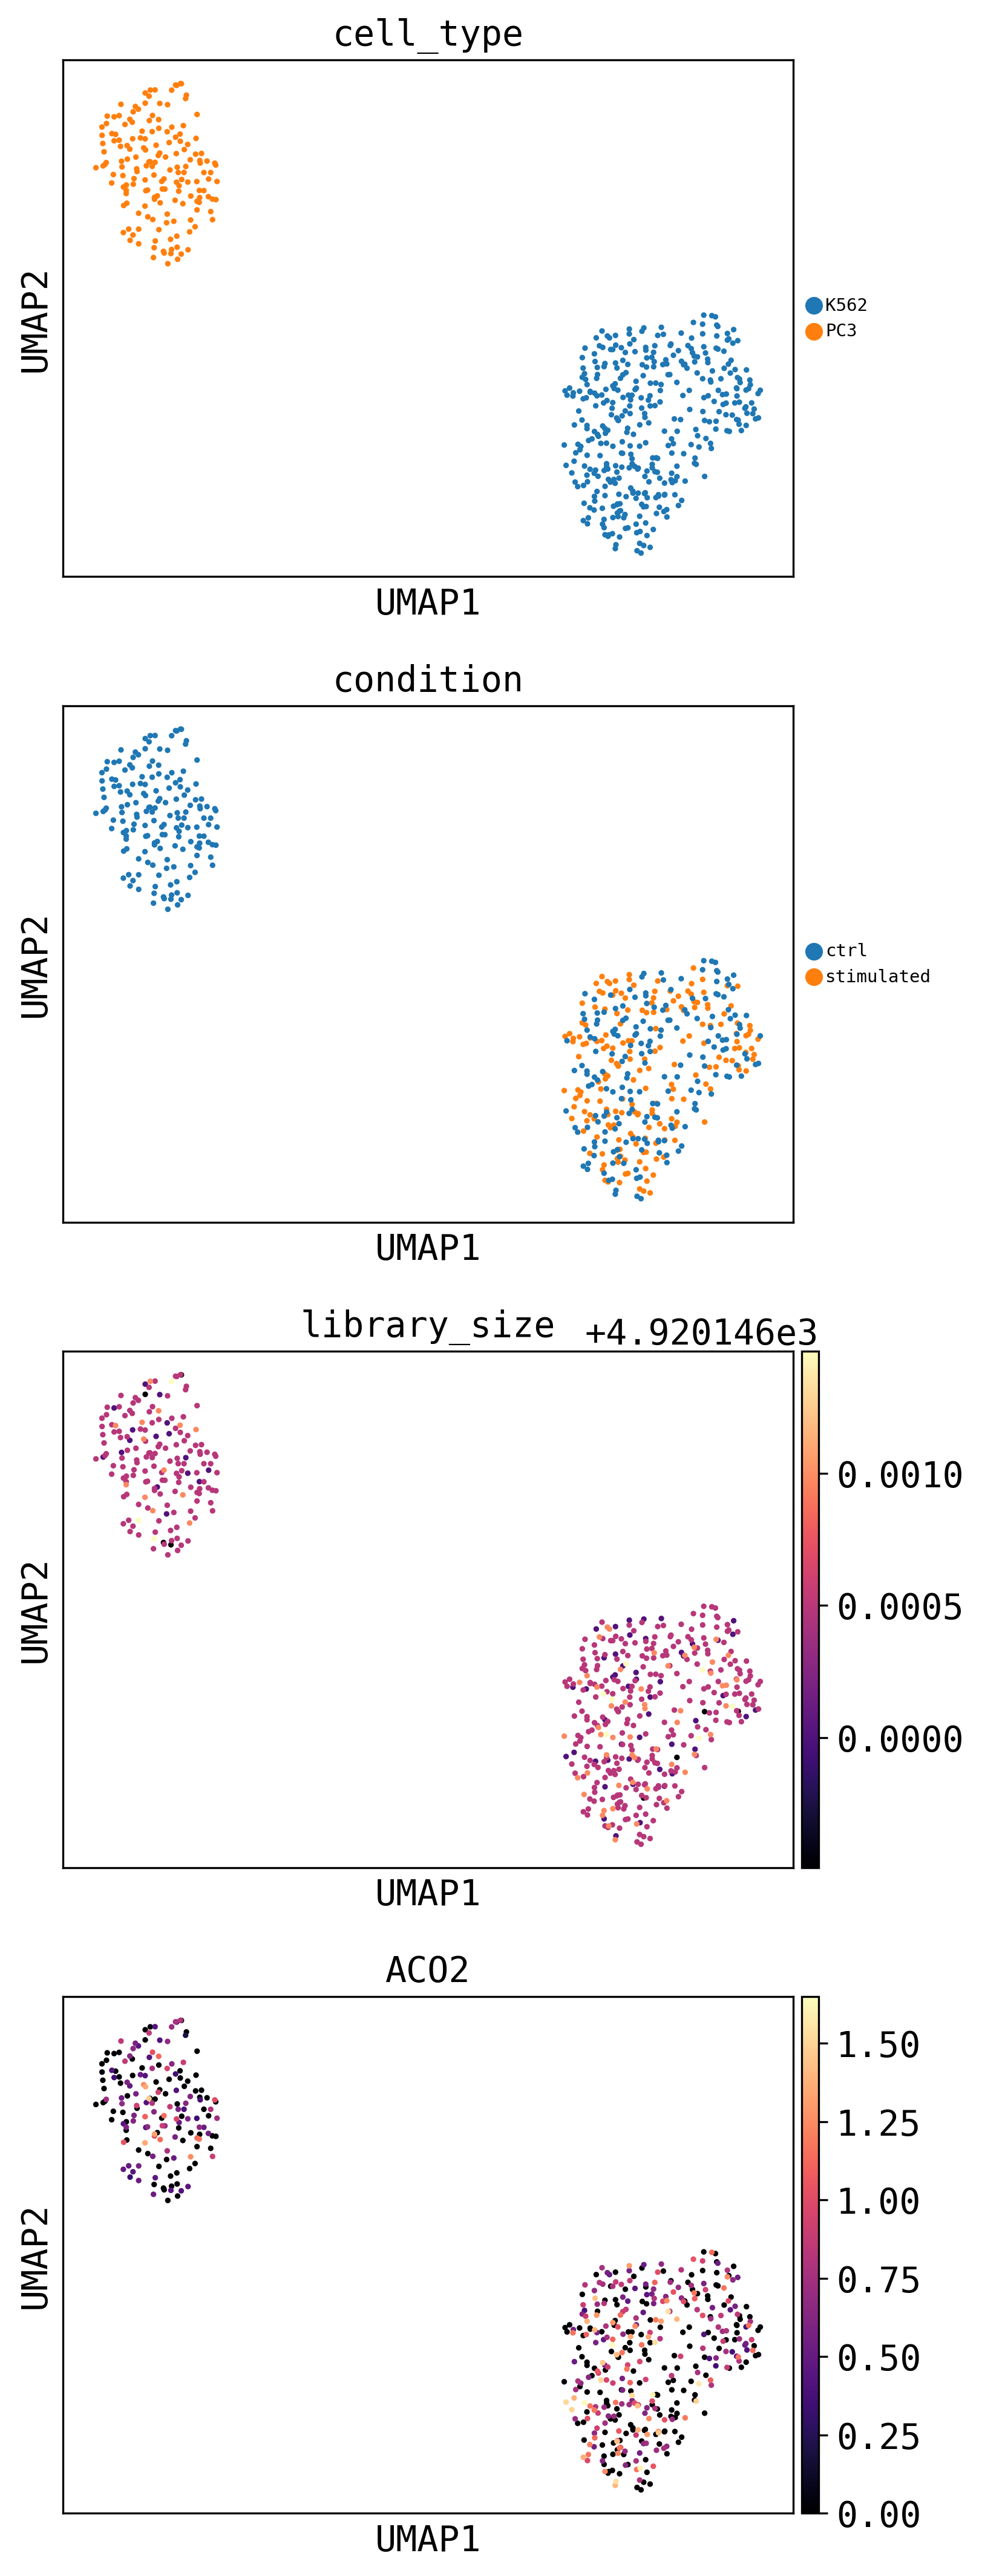

In [127]:
sc.settings.set_figure_params(dpi=150, facecolor='white')
# plt.rcParams["figure.figsize"] = [3, 4]

point_size = 20
color = ['cell_type',
         'condition',
         'library_size',
         'ACO2'
        #  'patient',
        # 'treatment',
        # 'sort',
        # 'CD8A'
        ]
sc.pl.umap(adata_sub, color=color,size=point_size,legend_fontsize=7,
           # color_map='magma',
           ncols=1, wspace=0.4,legend_loc='right margin',
           cmap='magma'
          )

In [130]:
# adata_pert, adata_ctrl

# debug - PC3有个pert error

In [85]:
pert

'ARF4'

In [86]:
# - get adata_pert and adata_ctrl
adata_pert = adata_K562_sub[adata_K562_sub.obs['perturbation_group']==pert+' | K562']
adata_ctrl = adata_K562_sub[list(adata_pert.obs['control_barcode'])]

adata_pert = adata_pert[:, common_var]
adata_ctrl = adata_ctrl[:, common_var]


# - get adata_rna_common
adata_rna_common = adata_rna[:, common_var]

# - generate adata_train to input to scGen model
np_list, obs_list, pert_list, celltype_list = [], [], [], []
pert_list_2 = []
adata_list = [adata_pert, adata_rna_common, adata_ctrl, adata_rna_common]
for j, adata_ in enumerate(adata_list):
    if j in [0, 1]:
        pert_list.extend(['stimulated']*len(adata_))
    else:
        pert_list.extend(['ctrl']*len(adata_))

    if j in [0, 2]:
        celltype_list.extend(['K562']*len(adata_))
    else:
        celltype_list.extend([cell_line_bulk]*len(adata_))
    obs_list.extend([obs+f'_{j}' for obs in adata_.obs_names])
    
    if not isinstance(adata_.X, np.ndarray):
        np_list.append(adata_.X.toarray())
    else:
        np_list.append(adata_.X)

adata_train = AnnData(X = np.vstack(np_list))
adata_train.obs_names = obs_list
adata_train.var_names = adata_pert.var_names

adata_train.obs['condition'] = pert_list
# adata_train.obs['condition_2'] = pert_list_2
adata_train.obs['cell_type'] = celltype_list

# - transform the adata_train.X to count
adata_train.obs['cov_cond'] = adata_train.obs['cell_type'] + '_' + adata_train.obs['condition']
adata_train.X = np.exp(adata_train.X)-1

In [87]:
adata_train

AnnData object with n_obs × n_vars = 726 × 3298
    obs: 'condition', 'cell_type', 'cov_cond'

In [90]:
adata_pert, adata_rna_common, adata_ctrl, adata_rna_common

(View of AnnData object with n_obs × n_vars = 194 × 3298
     obs: 'perturbation_group', 'control_barcode'
     var: 'chr', 'start', 'end', 'class', 'strand', 'length', 'in_matrix', 'mean', 'std', 'cv', 'fano', 'ensembl_id', 'ncounts', 'ncells'
     uns: 'log1p',
 View of AnnData object with n_obs × n_vars = 169 × 3298
     obs: 'Unnamed: 0', 'x', 'n_genes'
     var: 'Unnamed: 0', 'x', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
     uns: 'hvg', 'log1p',
 View of AnnData object with n_obs × n_vars = 194 × 3298
     obs: 'perturbation_group', 'control_barcode'
     var: 'chr', 'start', 'end', 'class', 'strand', 'length', 'in_matrix', 'mean', 'std', 'cv', 'fano', 'ensembl_id', 'ncounts', 'ncells'
     uns: 'log1p',
 View of AnnData object with n_obs × n_vars = 169 × 3298
     obs: 'Unnamed: 0', 'x', 'n_genes'
     var: 'Unnamed: 0', 'x', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
     uns: 'hvg', 'log1p')

In [79]:
# - initial model
cpa.CPA.setup_anndata(adata_train, 
                    perturbation_key='condition',
                    control_group='ctrl',
                    #   dosage_key='dose',
                    categorical_covariate_keys=['cell_type'],
                    is_count_data=True,
                    #   deg_uns_key='rank_genes_groups_cov',
                    deg_uns_cat_key='cov_cond',
                    max_comb_len=1,
                    )

# - set the train and validation for cpa
# -- get total obs_names of the pert
adata_train_new = adata_train[~((adata_train.obs["cell_type"] == cell_line_bulk) &
                    (adata_train.obs["condition"] == "stimulated"))].copy()
# obs_df_split = adata_train_new.obs
obs_df_sub_idx = np.array(adata_train_new.obs.index)

np.random.seed(2024)
np.random.shuffle(obs_df_sub_idx)

# -- data split
split_point_1 = int(len(obs_df_sub_idx) * 0.9)
split_point_2 = int(len(obs_df_sub_idx) * (0.9+0.1))
train = obs_df_sub_idx[:split_point_1]
valid = obs_df_sub_idx[split_point_1:split_point_2]


adata_train.obs['split_key'] = 'ood'

# -- set the test row
adata_train.obs.loc[train,'split_key'] = 'train'
adata_train.obs.loc[valid,'split_key'] = 'valid'

100%|██████████| 726/726 [00:00<00:00, 1031875.54it/s]

INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        


In [80]:

# - initial the model and training   
model = cpa.CPA(adata=adata_train, 
                split_key='split_key',
                train_split='train',
                valid_split='valid',
                test_split='ood',
                **model_params,
            )

Global seed set to 6977


In [88]:
adata_ctrl

View of AnnData object with n_obs × n_vars = 194 × 3298
    obs: 'perturbation_group', 'control_barcode'
    var: 'chr', 'start', 'end', 'class', 'strand', 'length', 'in_matrix', 'mean', 'std', 'cv', 'fano', 'ensembl_id', 'ncounts', 'ncells'
    uns: 'log1p'

In [89]:
adata_train_new

AnnData object with n_obs × n_vars = 557 × 3298
    obs: 'condition', 'cell_type', 'cov_cond', 'CPA_dose_val', 'CPA_cat', 'CPA_ctrl', '_scvi_condition', '_scvi_cell_type', '_scvi_CPA_cat'
    uns: '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'perts', 'perts_doses'

In [83]:

model.train(max_epochs=2000,
            use_gpu=True, 
            batch_size=512,
            plan_kwargs=trainer_params,
            early_stopping_patience=5,
            check_val_every_n_epoch=5,
            # save_path='../../datasets/',
            progress_bar_refresh_rate = 0
        )

100%|██████████| 2/2 [00:00<00:00, 785.16it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

Epoch 00004: cpa_metric reached. Module best state updated.

Epoch 00009: cpa_metric reached. Module best state updated.



disnt_basal = 1.3407936507936506
disnt_after = 1.4885714285714284
val_r2_mean = 0.05109703540802002
val_r2_var = -1.8553989728291829



Epoch 00014: cpa_metric reached. Module best state updated.

Epoch 00019: cpa_metric reached. Module best state updated.



disnt_basal = 1.3242857142857143
disnt_after = 1.4885714285714284
val_r2_mean = 0.440582017103831
val_r2_var = -1.8568131923675537



Epoch 00024: cpa_metric reached. Module best state updated.

Epoch 00029: cpa_metric reached. Module best state updated.



disnt_basal = 1.329047619047619
disnt_after = 1.4885714285714284
val_r2_mean = 0.6533900101979574
val_r2_var = -1.857723633448283



Epoch 00034: cpa_metric reached. Module best state updated.

Epoch 00039: cpa_metric reached. Module best state updated.



disnt_basal = 1.3058730158730159
disnt_after = 1.4885714285714284
val_r2_mean = 0.8448583086331686
val_r2_var = -1.857707420984904



Epoch 00044: cpa_metric reached. Module best state updated.

Epoch 00049: cpa_metric reached. Module best state updated.



disnt_basal = 1.3013373554550025
disnt_after = 1.4885714285714284
val_r2_mean = 0.9143341581026713
val_r2_var = -1.8550675710042317

disnt_basal = 1.3147338935574229
disnt_after = 1.4885714285714284
val_r2_mean = 0.9195351401964823
val_r2_var = -1.8475741545359294

disnt_basal = 1.323015873015873
disnt_after = 1.4885714285714284
val_r2_mean = 0.9111482898394266
val_r2_var = -1.8234585920969646


In [73]:
pert

'ARF4'

# debug

In [56]:
len((pert_gene_rank_dict['AATF'][1]))

5155

In [33]:
for cell_line_bulk in common_cell_line.keys():

    cell_line_single = common_cell_line[cell_line_bulk]
    print('='*20, f'cell line is {cell_line_single}')

    #===================prepare data
    if cell_line_bulk in ['PC3', 'A375']:
        save_dir_adata = '/nfs/public/lichen/results/single_cell_perturbation/perturbation_benchmark/benchmark_data/L1000/single_cell_data/SCP542'
        adata_rna = sc.read(os.path.join(save_dir_adata, cell_line_bulk, f'adata_{cell_line_bulk}.h5ad'))
        
        # - read adata_rna_raw
        save_dir = f'/nfs/public/lichen/data/single_cell/cell_line/SCP542/process/{cell_line_bulk}'
        adata_rna_raw = sc.read(os.path.join(save_dir, f'adata.h5ad'))

    else:
        save_dir_adata = '/nfs/public/lichen/results/single_cell_perturbation/perturbation_benchmark/benchmark_data/L1000/single_cell_data/CNP0003658'
        adata_rna = sc.read(os.path.join(save_dir_adata, cell_line_bulk, f'adata_{cell_line_bulk}.h5ad'))

        # - read adata_rna
        save_dir = f'/nfs/public/lichen/data/single_cell/cell_line/CNP0003658/process/RNA/{cell_line_single}'
        adata_rna_raw = sc.read(os.path.join(save_dir, f'adata_rna_{cell_line_single}.h5ad'))
        
    print(type(adata_rna.X))
    
    break

==================== cell line is A549
<class 'numpy.ndarray'>


In [35]:
adata_rna.X.toarray()

AttributeError: 'numpy.ndarray' object has no attribute 'toarray'

In [30]:
save_dir = '/nfs/public/lichen/results/single_cell_perturbation/perturbation_benchmark_202410/zero_shot/result'
save_prefix = f'CPA/{cell_line_bulk}' # use result of K562 to do the direct transfer
os.makedirs(os.path.join(save_dir, save_prefix), exist_ok=True)

import json
with open(os.path.join(save_dir, save_prefix, 'pert_gene_rank_dict.json'), 'w') as f:
    json.dump(pert_gene_rank_dict, f)

In [ ]:
adata_pert = adata_K562_sub[adata_K562_sub.obs['perturbation_group']==pert+' | K562']
adata_pert

View of AnnData object with n_obs × n_vars = 182 × 8248
    obs: 'perturbation_group', 'control_barcode'
    var: 'chr', 'start', 'end', 'class', 'strand', 'length', 'in_matrix', 'mean', 'std', 'cv', 'fano', 'ensembl_id', 'ncounts', 'ncells'
    uns: 'log1p'

In [32]:
adata_pert.X

<182x8248 sparse matrix of type '<class 'numpy.float32'>'
	with 567598 stored elements in Compressed Sparse Row format>

In [ ]:
adata_ctrl = adata_K562_sub[list(adata_pert.obs['control_barcode'])]

In [ ]:
tmp1 = list(adata_pert.obs['control_barcode'])
tmp2 = list(adata_K562_sub.obs_names)
len(np.intersect1d(tmp1, tmp2))

181

In [38]:
# adata_rna[:, common_var].X.toarray()

# function

In [47]:
def cpa_single_pert(pert, model_mode='whole'):
    
    # - get adata_pert and adata_ctrl
    adata_pert = adata_K562_sub[adata_K562_sub.obs['perturbation_group']==pert+' | K562']
    adata_ctrl = adata_K562_sub[list(adata_pert.obs['control_barcode'])]

    adata_pert = adata_pert[:, common_var]
    adata_ctrl = adata_ctrl[:, common_var]


    # - get adata_rna_common
    adata_rna_common = adata_rna[:, common_var]

    # - generate adata_train to input to scGen model
    np_list, obs_list, pert_list, celltype_list = [], [], [], []
    pert_list_2 = []
    adata_list = [adata_pert, adata_rna_common, adata_ctrl, adata_rna_common]
    for j, adata_ in enumerate(adata_list):
        if j in [0, 1]:
            pert_list.extend(['stimulated']*len(adata_))
        else:
            pert_list.extend(['ctrl']*len(adata_))

        if j in [0, 2]:
            celltype_list.extend(['K562']*len(adata_))
        else:
            celltype_list.extend([cell_line_bulk]*len(adata_))
        obs_list.extend([obs+f'_{j}' for obs in adata_.obs_names])
        
        if not isinstance(adata_.X, np.ndarray):
            np_list.append(adata_.X.toarray())
        else:
            np_list.append(adata_.X)

    adata_train = AnnData(X = np.vstack(np_list))
    adata_train.obs_names = obs_list
    adata_train.var_names = adata_pert.var_names

    adata_train.obs['condition'] = pert_list
    # adata_train.obs['condition_2'] = pert_list_2
    adata_train.obs['cell_type'] = celltype_list

    # - transform the adata_train.X to count
    adata_train.obs['cov_cond'] = adata_train.obs['cell_type'] + '_' + adata_train.obs['condition']
    adata_train.X = np.exp(adata_train.X)-1

    # - initial model
    cpa.CPA.setup_anndata(adata_train, 
                        perturbation_key='condition',
                        control_group='ctrl',
                        #   dosage_key='dose',
                        categorical_covariate_keys=['cell_type'],
                        is_count_data=True,
                        #   deg_uns_key='rank_genes_groups_cov',
                        deg_uns_cat_key='cov_cond',
                        max_comb_len=1,
                        )

    # - set the train and validation for cpa
    # -- get total obs_names of the pert
    adata_train_new = adata_train[~((adata_train.obs["cell_type"] == cell_line_bulk) &
                        (adata_train.obs["condition"] == "stimulated"))].copy()
    # obs_df_split = adata_train_new.obs
    obs_df_sub_idx = np.array(adata_train_new.obs.index)

    np.random.seed(2024)
    np.random.shuffle(obs_df_sub_idx)

    # -- data split
    split_point_1 = int(len(obs_df_sub_idx) * 0.9)
    split_point_2 = int(len(obs_df_sub_idx) * (0.9+0.1))
    train = obs_df_sub_idx[:split_point_1]
    valid = obs_df_sub_idx[split_point_1:split_point_2]


    adata_train.obs['split_key'] = 'ood'

    # -- set the test row
    adata_train.obs.loc[train,'split_key'] = 'train'
    adata_train.obs.loc[valid,'split_key'] = 'valid'

    # - initial the model and training   
    model = cpa.CPA(adata=adata_train, 
                    split_key='split_key',
                    train_split='train',
                    valid_split='valid',
                    test_split='ood',
                    **model_params,
                )

    model.train(max_epochs=2000,
                use_gpu=True, 
                batch_size=500,
                plan_kwargs=trainer_params,
                early_stopping_patience=5,
                check_val_every_n_epoch=5,
                # save_path='../../datasets/',
                progress_bar_refresh_rate = 0
            )

    # - predict result
    model.predict(adata_train, batch_size=2048)

    # - get the pred data
    cat = cell_line_bulk + '_' + 'stimulated'
    cat_adata = adata_train[adata_train.obs['cov_cond'] == cat].copy()
    x_pred = cat_adata.obsm['CPA_pred']
    x_pred = np.log1p(x_pred)

    if model_mode == 'subset':
        # - get pert_gene_rank_dict
        adata_ctrl = adata_rna_common.copy()
        adata_pert = adata_ctrl.copy()
        adata_pert.X = x_pred
        
    elif model_mode == 'whole':
        # - get pert_gene_rank_dict
        adata_ctrl = adata_rna.copy()
        adata_pert = adata_ctrl.copy()
        adata_pert.X = x_pred[:, common_idx]
    else:
        raise ValueError()
        

    adata_pert.obs_names = [i+f'_{pert}' for i in adata_pert.obs_names]
    adata_ctrl.obs['batch'] = 'ctrl'
    adata_pert.obs['batch'] = 'pert'

    import anndata as ad
    adata_concat = ad.concat([adata_ctrl, adata_pert])

    # - cal de genes
    rankby_abs = False

    sc.tl.rank_genes_groups(
        adata_concat,
        groupby='batch',
        reference='ctrl',
        rankby_abs=rankby_abs,
        n_genes=len(adata_concat.var),
        use_raw=False,
        method = 'wilcoxon'
    )
    de_genes = pd.DataFrame(adata_concat.uns['rank_genes_groups']['names'])
    pvals = pd.DataFrame(adata_concat.uns['rank_genes_groups']['pvals'])
    pvals_adj = pd.DataFrame(adata_concat.uns['rank_genes_groups']['pvals_adj'])
    scores = pd.DataFrame(adata_concat.uns['rank_genes_groups']['scores'])
    logfoldchanges = pd.DataFrame(adata_concat.uns['rank_genes_groups']['logfoldchanges'])

    # - get gene_score
    gene_score = pd.DataFrame({'gene':list(de_genes['pert']),
                                'z-score':list(scores['pert'])})

    return (list(de_genes['pert']), list(scores['pert']))